In [ ]:
# default_exp parse_gfs

### ParseGFS

# Notebook which takes GFS model data, filteres it to relevant avalanche regions and outputs it to regional .netcdf files

### uses env pangeo_small

### Notes: At least on my machine I found a few things were affecting the performance and stability of the disk operations
1. The Dask based operations either in Xarray or directly in Dask (using local cluster) where less efficient than just using joblib parallel.  So I tend ot use Xarray in single process mode and do the parallel work with joblib
2. The netcdf write operation wasn't very resiliant when running in parallel so I generally had to both limit any operations which were writing netcdf files to max of 4 cores as well as do some error checking on the files.

In [ ]:
#test_ignore
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
#export
import xarray as xr
import matplotlib.pyplot as plt
import datetime as dt
import pandas as pd
import salem
import numpy as np
import geopandas as gpd
import datetime
from joblib import Parallel, delayed
import os
import time

# Data structure

OAPMLData/

    1.RawWeatherData/
        gfs/
            <season>/
                /<state or country>/
    2.GFSDaily(x)Interpolation)/
    3.GFSFiltered(x)Interpolation)

## These parameters need to be set

In [ ]:
#test_ignore
season = '15-16'
state = 'Washington'
#snow_start_date = '2015-11-01'

interpolate = 1 #interpolation factor: whether we can to augment the data through lat/lon interpolation; 1 no interpolation, 4 is 4x interpolation

data_root = '/media/scottcha/E1/Data/OAPMLData/'

n_jobs = 4 #number of parallel processes, this processing is IO bound so don't set this too high

### Below here should be executed based on the above parameters

In [ ]:
#export
class ParseGFS:
    """Class which provides the basic utilities and processing to transform a set of GFS hourly weather file 
       to a set of filtered, aggregated and optionally interpolated netCDF files organized.
    """
    @staticmethod
    def season_to_snow_start_date(season):
        if season == '15-16':
            return '2015-11-01'
        elif season == '16-17':
            return '2016-11-01'
        elif season == '17-18':
            return '2017-11-01'
        elif season == '18-19':
            return '2018-11-01'
        elif season == '19-20':
            return '2019-11-01'
    
    def __init__(self, season, state, data_root, interpolate=1):
        """Initialize the class
        
        Keyword arguments:
        season: the season code (e.g., 15-16, 16-17) for the season you are processing
        state: the name of the state or country we are processing
        data_root: the root path of the data folders which contains the 1.RawWeatherData folder
        interpolate: the degree of interpolation (1x and 4x have been tested, 1x is default)        
        """
        self.season = season
        self.snow_start_date = ParseGFS.season_to_snow_start_date(season)
        self.state = state
        self.interpolate = interpolate
        self.data_root = data_root
        self.state_path = None
        
        #make sure these are correct, but these generally don't need to change
        if state == 'Washington':
            self.state_path = 'Washington'
        else:
            self.state_path = 'ColoradoUtah' #the nc file which contains the weather data contains both utah and colorado


        #Path to USAvalancheRegions.geojson in this repo
        self.region_path = '../Data' 
        #path to the gfs netcdf files for input
        self.dataset_path = data_root + '/1.RawWeatherData/gfs/' + season + '/' + self.state_path + '/'
        #output path for the result of the interpolation
        self.day_path = data_root + '2.GFSDaily' + str(interpolate) + 'xInterpolation/'+ season + '/'

        self.filtered_path = data_root + '3.GFSFiltered' + str(interpolate) + 'xInterpolation/'+ season + '/'

        #input file pattern as we'll read a full winter season in one pass
        self.file_pattern2 = '00.f0[0-2]*.nc'

        p = 181
        if season in ['15-16', '19-20']:
            p = 182 #leap years

        self.date_values_pd = pd.date_range(self.snow_start_date, periods=p, freq="D")
        
        print(self.dataset_path + ' Is Input Directory')
        print(self.day_path + ' Is output directory and input to filtering')
        print(self.filtered_path + ' Is output directory of filtering')
        
        #check dates end on April 30 which is the last day we support
        assert(self.date_values_pd[-1].month == 4)
        assert(self.date_values_pd[-1].day == 30)
        
        if not os.path.exists(self.day_path):
            os.makedirs(self.day_path)
            
        if not os.path.exists(self.filtered_path):
            os.makedirs(self.filtered_path)
    

    def resample(self, t):
        """
        Convert netcdf files which already pivot across levels
        from a full forcecast file which covers many days
        to one which only covers one day in the future
        also changes the data from hourly to daily min, avg, and max values
        
        Keyword arguments:
        t: the pandas datetime to process
        """
        
        print('On time: ' + str(t) + '\n')

        try:
            with xr.open_mfdataset(self.dataset_path + 'gfs.0p25.' + t + self.file_pattern2, combine='nested', concat_dim='time', parallel=False) as ds: 

                #make sure we are just getting the first 24 hours
                pd_t = pd.to_datetime(t)
                ds = ds.where(ds.time.dt.day == pd_t.day, drop=True)

                min_name_dict = {}
                max_name_dict = {}
                avg_name_dict = {}
                #print("Calcualting Variables")
                for k in ds.data_vars.keys():
                    min_name_dict[k] = k + '_min'
                    max_name_dict[k] = k + '_max'
                    avg_name_dict[k] = k + '_avg'

                #print("Reampling")
                resampled_ds = ds.resample(time='1d')
                min_1day = resampled_ds.min().rename(min_name_dict)
                max_1day= resampled_ds.max().rename(max_name_dict)
                avg_1day = resampled_ds.mean().rename(avg_name_dict)

                #print("Merging")
                merged_ds = xr.merge([min_1day, max_1day, avg_1day])
                try:
                    file = self.day_path + self.state_path + '_' + t + '.nc'
                    try:
                        if os.path.exists(file):
                            os.remove(file)                        
                    except OSError as e:
                        #can likely ignore
                        print('had remove error ' + format(e))
                        time.sleep(1)
                    merged_ds.to_netcdf(file)
                    merged_ds.close()
                except Exception as err:
                    return self.day_path + self.state_path + '_' + t + '.nc' + ' -- ' + format(err)
                    merged_ds.close()
        except OSError as err:
            print('Missing files for time: ' + t)
    
    @staticmethod
    def check_resample(dates):
        """
        method to check if there are any file open issues with the newly output files
        
        Keyword arguments:
        date: pandas dates to check
        """
        dates_with_errors = []
        for t in dates.strftime('%Y%m%d'):
            try:
                with xr.open_dataset(day_path + statePath + '_' + t + '.nc') as file:
                    file.close()
                continue                
            except: 
                dates_with_errors.append(t)
        return dates_with_errors
    
    def resample_local(self, jobs=4):
        """
        Executes the resample process on the local machine.
        Process is IO bound so don't overallocate n_jobs
        All-Nan Slice and Divide warnings can be ignored
            
        Keyword arguments:
        jobs: number of parallel processs to use (default = 4)
        """
        results = Parallel(n_jobs=jobs, backend="multiprocessing")(map(delayed(self.resample), self.date_values_pd.strftime('%Y%m%d')))
        
        redo = None
        if not any(results):
            print('No Errors')            
        else:
            print('Errors in some files')
            #get the dates for the files which had errors
            redo = [x.split('_')[1].split('.')[0] for x in results if x != None]
            
        if redo is not None:
            #a bit of a manual process to find and fix any errors which were introduced.
            #i'm not entirely sure why some of these errors are non-deterministic but
            #retrying them fixes them if there are no data corruption issues
            #for data corruption we just skip the data
            #sometimes the file is corrupt or locked so you need to make sure its deleted first

            #fix any errors
            redo2 = []
            for r in redo:
                b = resample(r)
                if b is not None:
                    redo2.append(b)
    
            #another pass to try and fix any file corruption issues
            redo = check_resample(date_values_pd)
            
            results = Parallel(n_jobs=1, backend="multiprocessing")(map(delayed(self.resample), redo))
            
        return results


    def interpolate_and_write(self, t):
        """
        interpolate and filter each day 
        don't use dask for this, much faster to process the files in parallel 
        
        Keyword arguments:
        t: the pandas datetime to process
        """
        #Read in all avy region shapes and metadata
        regions_df = gpd.read_file(self.region_path + '/USAvalancheRegions.geojson')
        #filter to just the ones where we have lables for training
        training_regions_df = regions_df[regions_df['is_training']==True].copy()

        #TODO: this needs to not rely on a code change to add a region
        if self.state == 'Washington':
            training_regions_df = training_regions_df[training_regions_df['center']=='Northwest Avalanche Center']
        elif self.state == 'Utah':
            training_regions_df = training_regions_df[training_regions_df['center']=='Utah Avalanche Center']
        elif self.state == 'Colorado':
            training_regions_df = training_regions_df[training_regions_df['center']=='Colorado Avalanche Information Center']

        training_regions_df.reset_index(drop=True, inplace=True)
        #open files which were previously resampled to a single day per file
        try:
            with xr.open_dataset(self.day_path + self.state_path + '_' + t + '.nc') as tmp_ds:                 
                print('On time: ' + str(t))

                new_lon = np.linspace(tmp_ds.longitude[0], tmp_ds.longitude[-1], tmp_ds.dims['longitude'] * self.interpolate)
                new_lat = np.linspace(tmp_ds.latitude[0], tmp_ds.latitude[-1], tmp_ds.dims['latitude'] * self.interpolate)
                interpolated_ds = tmp_ds.interp(latitude=new_lat, longitude=new_lon)

                subsets = []
                filenames = []
                errors = []
                redo_date = []
                date = tmp_ds.time.dt.strftime('%Y%m%d').values[0]
                for _, row in training_regions_df.iterrows():
                    #print("Calculating region: " + row['name'])
                    f = self.filtered_path + 'Region_' + row['name'] + '_' + date + '.nc'
                    try:
                        if self.interpolate == 1:
                            tmp_subset = interpolated_ds.salem.subset(geometry=row['geometry'])
                        else:
                            tmp_subset = interpolated_ds.salem.subset(geometry=row['geometry']).salem.roi(geometry=row['geometry'])
                    except ValueError:
                        errors.append('Value Error: Ensure the correct training regions have been provided')

                        continue

                    try:                
                        tmp_subset.to_netcdf(f)
                    except Exception as err:                                
                        os.remove(f)
                        errors.append(f + ' -- ' + format(err))
                        redo_date.append(date)
                        continue
        except OSError as err:
            print('Missing files for time: ' + t + 'with error ' + format(err))
            return None

        return (errors, redo_date)

    def interpolate_and_write_local(self, jobs=6):
        """
        Executes the interpolate and write process on the local machine.
        Process is IO bound so don't overallocate n_jobs
            
        Keyword arguments:
        jobs: number of parallel processs to use (default = 6)
        """
        
        results = Parallel(n_jobs=6, backend="multiprocessing")(map(delayed(self.interpolate_and_write), self.date_values_pd.strftime('%Y%m%d')))
        
        all_none = True
        for x in results:
            if x[0] == [] and x[1] == []:
                continue
            else:
                all_none = False
                break

        if all_none:
            print('No Errors, go to ConvertToZarr')
        else:
            print('errors in some files, redo those by calling interpolate_and_write on those specific files')
        
        return results

In [ ]:
#test_ignore
pgfs = ParseGFS(season, state, data_root)

/media/scottcha/E1/Data/OAPMLData//1.RawWeatherData/gfs/15-16/Washington/ Is Input Directory
/media/scottcha/E1/Data/OAPMLData/2.GFSDaily1xInterpolation/15-16/ Is output directory and input to filtering
/media/scottcha/E1/Data/OAPMLData/3.GFSFiltered1xInterpolation/15-16/ Is output directory of filtering


In [ ]:
#test_ignore
#limiting this to 4 jobs as fileio is the bottleneck
#n_jobs=4
#CPU times: user 1.11 s, sys: 551 ms, total: 1.66 s
#Wall time: 12min 22s

%time results = pgfs.resample_local()

On time: 20151101

On time: 20151102

On time: 20151103
On time: 20151104




/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN s

On time: 20151105

On time: 20151106

On time: 20151107

On time: 20151108



/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarni

On time: 20151109

On time: 20151110

On time: 20151111

On time: 20151112



/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return

On time: 20151113

On time: 20151114

On time: 20151115

On time: 20151116



/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarni

On time: 20151117

On time: 20151118

On time: 20151119

On time: 20151120



/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarni

On time: 20151121

On time: 20151122

On time: 20151123

On time: 20151124



/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarni

On time: 20151125

On time: 20151126

On time: 20151127

On time: 20151128



/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarni

On time: 20151129

On time: 20151130

On time: 20151201

On time: 20151202



/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarni

On time: 20151203

On time: 20151204

On time: 20151205

On time: 20151206



/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarni

On time: 20151207

On time: 20151208

On time: 20151209

On time: 20151210



/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarni

On time: 20151211

On time: 20151212

On time: 20151213

On time: 20151214



/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarni

On time: 20151215

On time: 20151216

On time: 20151217

On time: 20151218



/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarni

On time: 20151219

On time: 20151220

On time: 20151221

On time: 20151222



/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarni

On time: 20151223

On time: 20151224

On time: 20151225

On time: 20151226



/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarni

On time: 20151227

On time: 20151228

On time: 20151229

On time: 20151230



/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarni

On time: 20151231

On time: 20160101

On time: 20160102

On time: 20160103



/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarni

On time: 20160104

On time: 20160105

On time: 20160106

On time: 20160107



/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return

On time: 20160108

On time: 20160109

On time: 20160110

On time: 20160111



/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarni

On time: 20160112

On time: 20160113

On time: 20160114

On time: 20160115



/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarni

On time: 20160116

On time: 20160117

On time: 20160118

On time: 20160119



/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarni

On time: 20160120

On time: 20160121

On time: 20160122

On time: 20160123



/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarni

On time: 20160124

On time: 20160125

On time: 20160126

On time: 20160127



/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarni

On time: 20160128

On time: 20160129

On time: 20160130

On time: 20160131



/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarni

On time: 20160201

On time: 20160202

On time: 20160203

On time: 20160204



/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return

On time: 20160205

On time: 20160206

On time: 20160207

On time: 20160208



/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN s

On time: 20160209

On time: 20160210

On time: 20160211

On time: 20160212



/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return

On time: 20160213

On time: 20160214

On time: 20160215

On time: 20160216



/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarni

On time: 20160217

On time: 20160218

On time: 20160219

On time: 20160220



/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarni

On time: 20160221

On time: 20160222

On time: 20160223

On time: 20160224



/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarni

On time: 20160225

On time: 20160226

On time: 20160227

On time: 20160228



/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarni

On time: 20160229

On time: 20160301

On time: 20160302

On time: 20160303



/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarni

On time: 20160304

On time: 20160305

On time: 20160306

On time: 20160307



/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarni

On time: 20160308

On time: 20160309

On time: 20160310

On time: 20160311



/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarni

On time: 20160312

On time: 20160313

On time: 20160314

On time: 20160315



/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarni

On time: 20160316

On time: 20160317

On time: 20160318

On time: 20160319



/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarni

On time: 20160320

On time: 20160321

On time: 20160322

On time: 20160323



/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarni

On time: 20160324

On time: 20160325

On time: 20160326

On time: 20160327



/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarni

On time: 20160328

On time: 20160329

On time: 20160330

On time: 20160331



/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarni

On time: 20160401

On time: 20160402

On time: 20160403

On time: 20160404



/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarni

On time: 20160405

On time: 20160406

On time: 20160407

On time: 20160408



/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN s

On time: 20160409

On time: 20160410

On time: 20160411

On time: 20160412



/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN s

On time: 20160413

On time: 20160414

On time: 20160415

On time: 20160416



/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN s

On time: 20160417

On time: 20160418

On time: 20160419

On time: 20160420



/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarni

On time: 20160421

On time: 20160422

On time: 20160423

On time: 20160424



/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarni

On time: 20160425

On time: 20160426

On time: 20160427

On time: 20160428



/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarni

On time: 20160429

On time: 20160430



/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/utils.py:31: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/scottcha/anaconda3/envs/pangeo_small/lib/python3.7/site-packages/dask/array/numpy_compat.py:40: RuntimeWarni

No Errors
CPU times: user 1.28 s, sys: 481 ms, total: 1.77 s
Wall time: 12min 13s



## Now that the files are set to daily files on disk
go through them and interpolate them as a data augmentation task
this method also filters the data down to only valid avy regions as defined
in the geojson file USAvalancheRegions.geojson

In [ ]:
#test_ignore
%time results = pgfs.interpolate_and_write_local()

On time: 20151102
On time: 20151101
On time: 20151103
On time: 20151105
On time: 20151104
On time: 20151106
On time: 20151107
On time: 20151108
On time: 20151109
On time: 20151110
On time: 20151111
On time: 20151112
On time: 20151113
On time: 20151114
On time: 20151115
On time: 20151116
On time: 20151117
On time: 20151118
On time: 20151119
On time: 20151120
On time: 20151121
On time: 20151122
On time: 20151123
On time: 20151124
On time: 20151125
On time: 20151126
On time: 20151127
On time: 20151128
On time: 20151129
On time: 20151130
On time: 20151201
On time: 20151202
On time: 20151203
On time: 20151204
On time: 20151205
On time: 20151206
On time: 20151207
On time: 20151208
On time: 20151209
On time: 20151210
On time: 20151211
On time: 20151212
On time: 20151213
On time: 20151214
On time: 20151215
On time: 20151216
On time: 20151217
On time: 20151218
On time: 20151219
On time: 20151220
On time: 20151221
On time: 20151222
On time: 20151223
On time: 20151224
On time: 20151225
On time: 2

KeyboardInterrupt: 

In [ ]:
#test_ignore
#it seems that n_jobs > 8 introdces a lot of errors in to the netcdf write
#n_jobs = 4
#CPU times: user 1.83 s, sys: 830 ms, total: 2.66 s
#Wall time: 45min 18s
%time results = Parallel(n_jobs=6, backend="multiprocessing")(map(delayed(interpolate_and_write), date_values_pd.strftime('%Y%m%d')))

On time: 20181106
On time: 20181105
On time: 20181103
On time: 20181101
On time: 20181104
On time: 20181102
On time: 20181107
On time: 20181108
On time: 20181109
On time: 20181110
On time: 20181111
On time: 20181112
On time: 20181113
On time: 20181114
On time: 20181115
On time: 20181116
On time: 20181117
On time: 20181118
On time: 20181119
On time: 20181120
On time: 20181121
On time: 20181122
On time: 20181123
On time: 20181124
On time: 20181125
On time: 20181126
On time: 20181127
On time: 20181128
On time: 20181129
On time: 20181130
On time: 20181201
On time: 20181202
On time: 20181203
On time: 20181204
On time: 20181205
On time: 20181206
On time: 20181207
On time: 20181208
On time: 20181209
On time: 20181210
On time: 20181211
On time: 20181212
On time: 20181213
On time: 20181214
On time: 20181215
On time: 20181216
On time: 20181217
On time: 20181218
On time: 20181219
On time: 20181220
On time: 20181221
On time: 20181222
On time: 20181223
On time: 20181224
On time: 20181225
On time: 2

In [ ]:
#test_ignore
all_none = True
for x in results:
    if x[0] == [] and x[1] == []:
        continue
    else:
        all_none = False
        break

if all_none:
    print('Can skip next redo cells--go to Notebook 2.ConvertToZarr')
else:
    print('errors in some files, go to next cell to redo those specific files')
    

Can skip next redo cells--go to Notebook 2.ConvertToZarr


## Only need to continue beyond here if there are errors in the results

In [ ]:
#test_ignore
#individually fix any potenital file write errors
redo = ['20181103', '20181105', '20181220', '20181225', '20181226', '20190104', '20190214', '20190222', '20190224', '20190403']
#fix any errors
redo2 = []
for r in redo:
    print('on ' + r)
    a, b = interpolate_and_write(r)
    if len(b) > 0:
        redo2.append(b)

on 20181103
On time: 20181103
on 20181105
On time: 20181105
on 20181220
On time: 20181220
on 20181225
On time: 20181225
on 20181226
On time: 20181226
on 20190104
On time: 20190104
on 20190214
On time: 20190214
on 20190222
On time: 20190222
on 20190224
On time: 20190224
on 20190403
On time: 20190403


In [ ]:
#test_ignore
redo2

[['20181202']]

In [ ]:
#test_ignore
results, redo = Parallel(n_jobs=4, backend="multiprocessing")(map(delayed(interpolate_and_write), redo2))

On time: 20151102
On time: 20151114
On time: 20151115
On time: 20151113


RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

On time: 20151119


RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

On time: 20151112
On time: 20151118
On time: 20151204


RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

On time: 20151208


RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

On time: 20151104
On time: 20151107
On time: 20151116


RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

On time: 20151214


RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

On time: 20151117


RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

RuntimeError: NetCDF: HDF error

In [ ]:
#test_ignore
redo2

['20151102',
 '20151114',
 '20151113',
 '20151115',
 '20151119',
 '20151112',
 '20151118',
 '20151204',
 '20151208',
 '20151104',
 '20151107',
 '20151116',
 '20151214',
 '20151117']

In [ ]:
#test_ignore
interpolate_and_write('20181202')

On time: 20181202


([], [])

In [ ]:
#test_ignore
#another function to check that the netcdf files were all written correctly
def check_interpolate(filename):
    errors = []
    
    if filename.endswith(".nc") and filename:
        try:
            with xr.open_dataset(directory + filename) as file:
                file.close()            
        except:
            return filename

In [ ]:
#test_ignore
directory = filtered_path + '/'
files = [x for x in os.listdir(directory) if x.split('_')[1].split('.')[0] in '.nc'] # os.listdir(directory):
redo = Parallel(n_jobs=12, backend="multiprocessing")(map(delayed(check_interpolate), files))

In [ ]:
#test_ignore
redo2 = list(set([x.split('_')[2].split('.')[0] for x in redo if 'Steamboat' in x and '2015' in x]))

# Everything below here is debug or helper code 

In [ ]:
#test_ignore
xr.open_dataset(directory + 'Region_WA Cascades East, Central_20151119.nc')

<xarray.Dataset>
Dimensions:                                               (latitude: 23, longitude: 19, time: 1)
Coordinates:
  * time                                                  (time) datetime64[ns] ...
  * latitude                                              (latitude) float64 ...
  * longitude                                             (longitude) float64 ...
Data variables:
    UGRD_planetaryboundarylayer_min                       (time, latitude, longitude) float64 ...
    VGRD_planetaryboundarylayer_min                       (time, latitude, longitude) float64 ...
    VRATE_planetaryboundarylayer_min                      (time, latitude, longitude) float64 ...
    GUST_surface_min                                      (time, latitude, longitude) float64 ...
    HGT_10mb_min                                          (time, latitude, longitude) float64 ...
    TMP_10mb_min                                          (time, latitude, longitude) float64 ...
    RH_10mb_min                                           (time, latitude, longitude) float64 ...
    UGRD_10mb_min                                         (time, latitude, longitude) float64 ...
    VGRD_10mb_min                                         (time, latitude, longitude) float64 ...
    ABSV_10mb_min                                         (time, latitude, longitude) float64 ...
    O3MR_10mb_min                                         (time, latitude, longitude) float64 ...
    HGT_20mb_min                                          (time, latitude, longitude) float64 ...
    TMP_20mb_min                                          (time, latitude, longitude) float64 ...
    RH_20mb_min                                           (time, latitude, longitude) float64 ...
    UGRD_20mb_min                                         (time, latitude, longitude) float64 ...
    VGRD_20mb_min                                         (time, latitude, longitude) float64 ...
    ABSV_20mb_min                                         (time, latitude, longitude) float64 ...
    O3MR_20mb_min                                         (time, latitude, longitude) float64 ...
    HGT_30mb_min                                          (time, latitude, longitude) float64 ...
    TMP_30mb_min                                          (time, latitude, longitude) float64 ...
    RH_30mb_min                                           (time, latitude, longitude) float64 ...
    UGRD_30mb_min                                         (time, latitude, longitude) float64 ...
    VGRD_30mb_min                                         (time, latitude, longitude) float64 ...
    ABSV_30mb_min                                         (time, latitude, longitude) float64 ...
    O3MR_30mb_min                                         (time, latitude, longitude) float64 ...
    HGT_50mb_min                                          (time, latitude, longitude) float64 ...
    TMP_50mb_min                                          (time, latitude, longitude) float64 ...
    RH_50mb_min                                           (time, latitude, longitude) float64 ...
    UGRD_50mb_min                                         (time, latitude, longitude) float64 ...
    VGRD_50mb_min                                         (time, latitude, longitude) float64 ...
    ABSV_50mb_min                                         (time, latitude, longitude) float64 ...
    O3MR_50mb_min                                         (time, latitude, longitude) float64 ...
    HGT_70mb_min                                          (time, latitude, longitude) float64 ...
    TMP_70mb_min                                          (time, latitude, longitude) float64 ...
    RH_70mb_min                                           (time, latitude, longitude) float64 ...
    UGRD_70mb_min                                         (time, latitude, longitude) float64 ...
    VGRD_70mb_min                                         (time, latitude, longitu

In [ ]:
#test_ignore
#gets the variables and long names so we can understand what the model is covering
def get_variables(ds):
    #find all variables in the data set and their descriptions
    attrib_key = 'long_name' #'GRIB_name'
    variables = []
    i = 0
    for var in list(ds.data_vars.keys()):
        variables.append((i, var,ds[var].attrs[attrib_key]))
        i += 1

    return variables

In [ ]:
#test_ignore
#list of all the variables
get_variables(ds)

[(0, 'UGRD_planetaryboundarylayer', 'U-Component of Wind'),
 (1, 'VGRD_planetaryboundarylayer', 'V-Component of Wind'),
 (2, 'VRATE_planetaryboundarylayer', 'Ventilation Rate'),
 (3, 'GUST_surface', 'Wind Speed (Gust)'),
 (4, 'HGT_10mb', 'Geopotential Height'),
 (5, 'TMP_10mb', 'Temperature'),
 (6, 'RH_10mb', 'Relative Humidity'),
 (7, 'UGRD_10mb', 'U-Component of Wind'),
 (8, 'VGRD_10mb', 'V-Component of Wind'),
 (9, 'ABSV_10mb', 'Absolute Vorticity'),
 (10, 'O3MR_10mb', 'Ozone Mixing Ratio'),
 (11, 'HGT_20mb', 'Geopotential Height'),
 (12, 'TMP_20mb', 'Temperature'),
 (13, 'RH_20mb', 'Relative Humidity'),
 (14, 'UGRD_20mb', 'U-Component of Wind'),
 (15, 'VGRD_20mb', 'V-Component of Wind'),
 (16, 'ABSV_20mb', 'Absolute Vorticity'),
 (17, 'O3MR_20mb', 'Ozone Mixing Ratio'),
 (18, 'HGT_30mb', 'Geopotential Height'),
 (19, 'TMP_30mb', 'Temperature'),
 (20, 'RH_30mb', 'Relative Humidity'),
 (21, 'UGRD_30mb', 'U-Component of Wind'),
 (22, 'VGRD_30mb', 'V-Component of Wind'),
 (23, 'ABSV_30

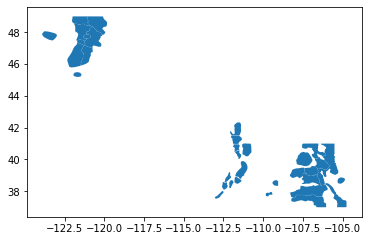

In [ ]:
#test_ignore
#review the training regions geojson
training_regions_df.geometry.plot()

In [ ]:
#lon needs to be 0-360
#not needed for nc files as wgrib2 already does this conversion
#training_regions_df.loc[:,'geometry'] = training_regions_df.translate(360,0)

In [ ]:
#test_ignore
print(training_regions_df['geometry'][49])

POLYGON ((-123.437858 48.026087, -123.23695 47.974945, -123.123965 47.937633, -123.023858 47.899013, -122.994157 47.849742, -122.98579 47.806763, -122.992001 47.760979, -123.025541 47.708388, -123.062294 47.6492, -123.22403 47.49742, -123.293695 47.491354, -123.462828 47.533471, -123.497097 47.545378, -123.592243 47.588468, -123.799435 47.703362, -123.831774 47.74392, -123.894959 47.824463, -123.909086 47.889784, -123.901611 47.925517, -123.798236 48.041375, -123.773643 48.059557, -123.746519 48.065784, -123.639185 48.057868, -123.552344 48.048375, -123.437858 48.026087))


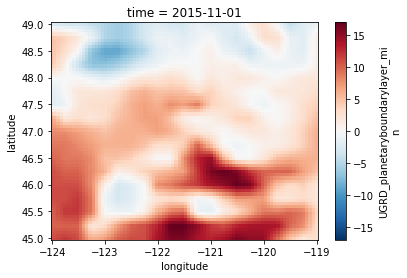

In [ ]:
#test_ignore
interpolated_ds.UGRD_planetaryboundarylayer_min[0].plot()

In [ ]:
#test_ignore
training_regions_df.head()

name                                 center  \
18                Aspen Zone  Colorado Avalanche Information Center   
19          Front Range Zone  Colorado Avalanche Information Center   
20           Grand Mesa Zone  Colorado Avalanche Information Center   
21             Gunnison Zone  Colorado Avalanche Information Center   
22  North San Juan Mountains  Colorado Avalanche Information Center   

                       center_link        timezone center_id state  \
18  https://avalanche.state.co.us/  America/Denver      CAIC    CO   
19  https://avalanche.state.co.us/  America/Denver      CAIC    CO   
20  https://avalanche.state.co.us/  America/Denver      CAIC    CO   
21  https://avalanche.state.co.us/  America/Denver      CAIC    CO   
22  https://avalanche.state.co.us/  America/Denver      CAIC    CO   

    is_training    color                                               link  \
18         True  #ff9933  http://avalanche.state.co.us/forecasts/backcou...   
19         True  #f4e500  http://avalanche.state.co.us/forecasts/backcou...   
20         True  #ff9933  http://avalanche.state.co.us/forecasts/backcou...   
21         True  #ff9933  http://avalanche.state.co.us/forecasts/backcou...   
22         True  #f4e500  http://avalanche.state.co.us/forecasts/backcou...   

                                             geometry  
18  POLYGON ((-106.91164 39.58375, -106.94518 39.5...  
19  POLYGON ((-105.46760 39.03134, -105.32958 39.0...  
20  POLYGON ((-108.19110 39.28692, -108.26556 39.1...  
21  POLYGON ((-106.91731 38.99704, -106.94591 39.0...  
22  POLYGON ((-106.29307 37.66569, -106.26690 37.7...

In [ ]:
#test_ignore
%time tmp_df = interpolated_ds.salem.subset(geometry=training_regions_df['geometry'][1]).salem.roi(geometry=training_regions_df['geometry'][1])


CPU times: user 7.25 s, sys: 92.4 ms, total: 7.34 s
Wall time: 7.25 s


In [ ]:
#test_ignore
%time tmp_df2 = tmp_df.chunk({'time': -1}).interpolate_na(dim='time')

CPU times: user 5min 31s, sys: 3.16 s, total: 5min 34s
Wall time: 5min 31s


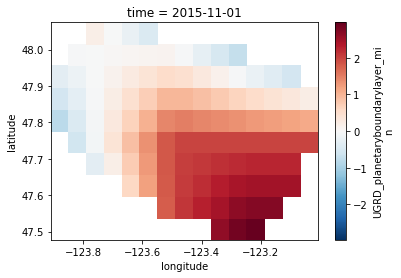

In [ ]:
#test_ignore
tmp_df2.UGRD_planetaryboundarylayer_min[0].plot()

In [ ]:
#This is code to filter to all the potential world avy locations
#avy_regions_shp = salem.read_shapefile('../../GetTrainingData/CreateGlobalAvyRegions/WorldAvyRegionsShapeV2/WorldAvyRegionsV2.shp')
#avy_regions_shp.plot()
#avy_regions_shp2 = avy_regions_shp.translate(360,0)
#avy_regions_shp2[0]
#merged_filtered_ds = merged_interpolated_ds.salem.roi(geometry=avy_regions_shp2[0])
#this is the filtered snowdepths for the first day in the dataset
#merged_filtered_ds.avg_sde[100].plot()